In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

/Users/sarveshrawat/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [54]:
from nltk.corpus import stopwords
import re
from nltk.tokenize import RegexpTokenizer

In [67]:
stemmer = PorterStemmer()
regtokeniz = RegexpTokenizer(r'\w+')

In [2]:
con = sqlite3.connect('database.sqlite')

In [4]:
messages=pd.read_sql("SELECT Score, Summary from Reviews where Score != 3", con)
def partition(x):
    if x>3:
        return 'Positive'
    else:
        return 'Negative'
        

In [6]:
score= messages['Score']
messages['Score']= score.apply(partition)

In [9]:
Summary = messages['Summary']
Score= messages['Score']
messages.head(2)

,Score,Summary
0,Positive,Good Quality Dog Food
1,Negative,Not as Advertised


In [239]:
X_train, X_test, y_train, y_test = train_test_split(Summary, Score, test_size=0.2, random_state=42)

In [17]:
def stem (words):
    stem=[]
    for i in words:
        stem.append(stemmer.stem(i))
    return stem  

In [73]:
X_train.head(2)

496497                                    ALMONDS GREAT BUY
225396    I never thought i'd have to say no to more fru...
Name: Summary, dtype: object

In [77]:
def tok (text):
    token= text.lower()
    #token=regtokeniz.tokenize(token)
    token =re.sub("[^a-zA-Z]", " " , token) # used to remove puncuation we can use the "maketrans" also.
    token=nltk.word_tokenize(token)
    word= set(stopwords.words('english'))
    new_Words= [w for w in token if text not in word]
    after_Stem= stem(new_Words)
    return " ".join(after_Stem)   

In [64]:
# We can use the regex to remove the puncuation.
intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

In [84]:
X_train.head(2)

496497                                    ALMONDS GREAT BUY
225396    I never thought i'd have to say no to more fru...
Name: Summary, dtype: object

In [78]:
corp=[]
for train in X_train:
    #texts = train.translate(trantab)
    text= tok(train)
    corp.append(text)

In [87]:
pd.DataFrame(corp).head()

,0
0,almond great buy
1,i never thought i d have to say no to more fru...
2,we love thi stuff
3,fan friggen tastic
4,great for offic


In [79]:
count_vector= CountVectorizer()
X_train_counts= count_vector.fit_transform(corp)
# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [108]:
test_set=[]
for train in X_test:
    texts = train.translate(trantab)
    text= tok(train)
    test_set.append(text)
    
X_new_counts = count_vector.transform(test_set)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)    


In [88]:
df = pd.DataFrame({'Before': X_train, 'After': corp})
print(df.head(5))

                                                    After  \
496497                                   almond great buy   
225396  i never thought i d have to say no to more fru...   
288197                                  we love thi stuff   
88450                                  fan friggen tastic   
354669                                    great for offic   

                                                   Before  
496497                                  ALMONDS GREAT BUY  
225396  I never thought i'd have to say no to more fru...  
288197                                 We love this Stuff  
88450                                  Fan-friggen-tastic  
354669                                   Great for office  


In [214]:
prediction = {}

# Applying Multinomial Naïve Bayes learning method

In [197]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
a = model.predict(X_test_tfidf)

# Applying Bernoulli Naïve Bayes learning method

In [110]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

In [250]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
log_Reg= logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

In [142]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.80      0.69      0.74     16379
   negative       0.94      0.97      0.96     88784

avg / total       0.92      0.93      0.92    105163



In [152]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(Score)))
    
    plt.xticks(tick_marks, set(Score), rotation=45)
    plt.yticks(tick_marks, set(Score))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


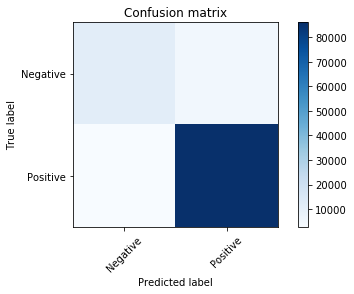

In [154]:
# Compute confusion matrix
cm = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

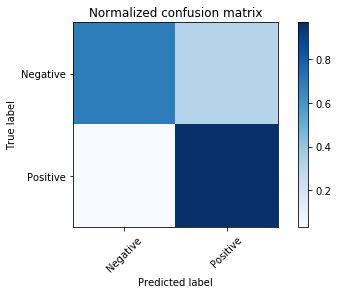

In [155]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [112]:
def formatt(x):
    if x== "negative":
        return 0
    return 1

vfunc = np.vectorize(formatt)

In [113]:
cmp=0
colors = ['b', 'g', 'y', 'm', 'k']

In [216]:
vfunc(predicted)

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
true_positive_rate, false_positive_rate, threshold = roc_curve(y_test.map(formatt), a)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
   

In [ ]:
for model, predicted in prediction.items():
    true_positive_rate, false_positive_rate = roc_curve(y_test.map(formatt), vfunc(predicted))
    

In [191]:
vfunc(predicted)
#y_test.map(formatt)

array([1, 1, 1, ..., 1, 1, 1])

# Different approach

In [242]:
con = sqlite3.connect('database.sqlite')

messages = pd.read_sql_query("""
SELECT Score, Summary
FROM Reviews
WHERE Score != 3
""", con)

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

Score = messages['Score']
Score = Score.map(partition)
Summary = messages['Summary']
X_train, X_test, y_train, y_test = train_test_split(Summary, Score, test_size=0.2, random_state=42)

In [243]:
stemmer = PorterStemmer()
from nltk.corpus import stopwords

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    #tokens = [word for word in tokens if word not in stopwords.words('english')]
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

#--- Training set

corpus = []
for text in X_train:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus.append(text)
        
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(corpus)        
        
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#--- Test set

test_set = []
for text in X_test:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    test_set.append(text)

X_new_counts = count_vect.transform(test_set)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

from pandas import *
df = DataFrame({'Before': X_train, 'After': corpus})
print(df.head(20))

prediction = dict()

                                                    After  \
496497                                   almond great buy   
225396  i never thought i d have to say no to more fru...   
288197                                  we love thi stuff   
88450                                  fan friggen tastic   
354669                                    great for offic   
331410                                what have they done   
456920                                      cri babi tear   
261055      good cereal with a few potenti health concern   
295869                                       a quick meal   
149914                                        good flavor   
368576                                 best bbq sauc ever   
192328                        best lemonad mix ive bought   
123408     if you like the tast of chai you will love thi   
114477               the best basic ramen noodl out there   
108795                                           huge bag   
315703                  

In [244]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

In [245]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

[ 0.    0.55  1.  ]
[2 1 0]
[ 0.    0.99  1.  ]
0.719566364739
[ 0.    0.35  1.  ]
[2 1 0]
[ 0.    0.96  1.  ]
0.800822910775


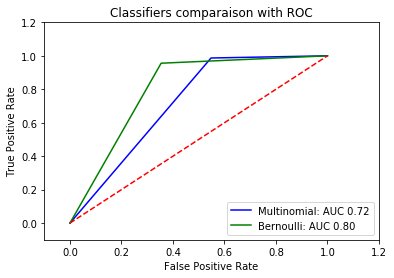

In [247]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print (false_positive_rate)
    print (thresholds)
    print (true_positive_rate)
    print (roc_auc)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Best words and worst words  by looking at the coefficients of Logistic regression:

In [264]:
log_Reg.coef_

array([[-1.87, -0.22,  6.17, ...,  7.19, -3.77,  5.8 ]])

In [269]:
words = count_vector.get_feature_names()
feature_coefs= pd.DataFrame( 
                       data = list(zip(words,log_Reg.coef_[0])),
                       columns = ['feature','coef'] )
feature_coefs.sort_values(by='coef').head(10)

,feature,coef
4204,costamar,-30.298795
12375,moolah,-29.777046
15281,puzzl,-28.171209
13307,octi,-27.759383
15446,rainforest,-27.561612
12947,nitrit,-27.537582
17522,smurf,-27.359882
21410,xclnt,-27.131613
19980,ultrarunn,-27.082295
11445,mambi,-27.067745


# Testing some random data.

In [286]:
def test_sample(model, sample):
    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    print (result)
    result = model.predict(sample_tfidf)
    print (result)
    prob = model.predict_proba(sample_tfidf)[0]
    print (prob)
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result[0], prob[0], prob[1]))

test_sample(logreg, "The food was delicious, it smelled great and the taste was awesome")
test_sample(logreg, "The whole experience was horrible. The smell was so bad that it literally made me sick.")
test_sample(logreg, "The food was ok, I guess. The smell wasn't very good, but the taste was ok.")

positive
['positive']
[  1.67e-04   1.00e+00]
Sample estimated as positive: negative prob 0.000167, positive prob 0.999833
negative
['negative']
[ 0.89  0.11]
Sample estimated as negative: negative prob 0.891462, positive prob 0.108538
positive
['positive']
[ 0.16  0.84]
Sample estimated as positive: negative prob 0.157625, positive prob 0.842375


In [287]:
con = sqlite3.connect('database.sqlite')
pd.read_sql_query("SELECT * FROM Reviews LIMIT 3", con)
messages = pd.read_sql_query("""
SELECT 
  Score, 
  Summary, 
  HelpfulnessNumerator as VotesHelpful, 
  HelpfulnessDenominator as VotesTotal
FROM Reviews 
WHERE Score != 3""", con)

In [288]:
messages.head(5)

,Score,Summary,VotesHelpful,VotesTotal
0,5,Good Quality Dog Food,1,1
1,1,Not as Advertised,0,0
2,4,"""Delight"" says it all",1,1
3,2,Cough Medicine,3,3
4,5,Great taffy,0,0


In [290]:
messages['Sentiment']= messages['Score'].apply(lambda x: "positive" if x>3 else "negative" )
messages["Usefulness"]= (messages['VotesHelpful']/messages['VotesTotal']).apply(lambda x: "useful" if x>0.8 
                                                                                else "useless")

In [292]:
messages.head(5)

,Score,Summary,VotesHelpful,VotesTotal,Sentiment,Usefulness
0,5,Good Quality Dog Food,1,1,positive,useful
1,1,Not as Advertised,0,0,negative,useless
2,4,"""Delight"" says it all",1,1,positive,useful
3,2,Cough Medicine,3,3,negative,useful
4,5,Great taffy,0,0,positive,useless


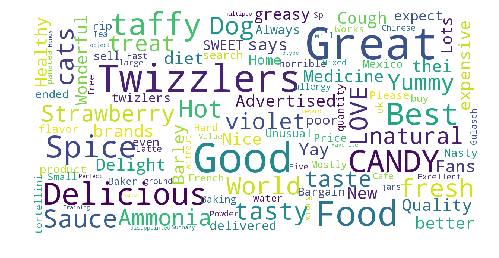

In [294]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(messages["Summary"])

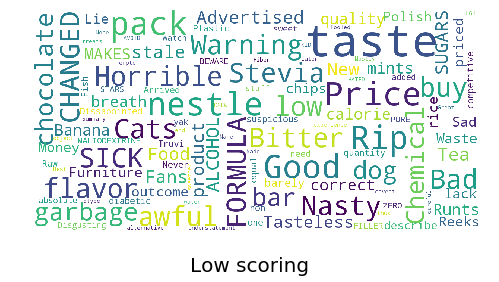

In [295]:
show_wordcloud(messages[messages['Score'] == 1]["Summary"], title = "Low scoring")

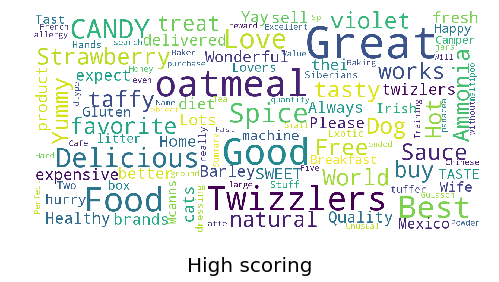

In [296]:
show_wordcloud(messages[messages.Score == 5]["Summary"], title = "High scoring")

# To see how helpful a product is

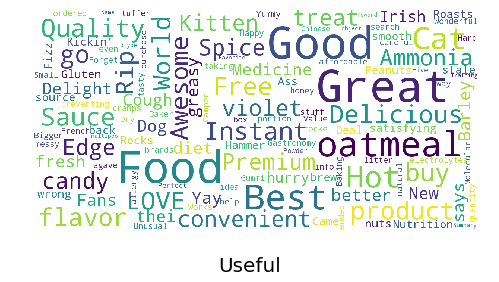

In [297]:
show_wordcloud(messages[messages.Usefulness == "useful"]["Summary"], title = "Useful")

In [371]:
# Nothin is clear above. Let's try to limit the dataset to only entries with at least 10 votes.
messages_ufn = messages[messages.VotesTotal >= 10]
messages_ufn.head()

,Score,Summary,VotesHelpful,VotesTotal,Sentiment,Usefulness
32,4,Best of the Instant Oatmeals,19,19,positive,useful
33,4,Good Instant,13,13,positive,useful
75,5,Forget Molecular Gastronomy - this stuff rocke...,15,15,positive,useful
145,5,tastes very fresh,17,19,positive,useful
195,1,CHANGED FORMULA MAKES CATS SICK!!!!,3,10,negative,useless


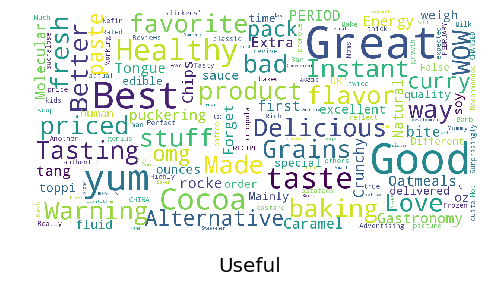

In [300]:
show_wordcloud(messages_ufn[messages_ufn.Usefulness == "useful"]["Summary"], title = "Useful")

This Looks better

In [391]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

train_ufn, test_ufn = train_test_split(messages_ufn, test_size=0.2)
ufn_pipe= Pipeline([
    ('vect', CountVectorizer(min_df= 1,ngram_range=(1,4))),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(C=1e5)),                   
])


ufn_result = ufn_pipe.fit(train_ufn['Summary'], train_ufn['Usefulness'])
prediction['Logistic_Usefulness'] = ufn_pipe.predict(test_ufn["Summary"])


In [392]:
test_ufn["Usefulness"].head(4)

461098     useful
445669    useless
29420      useful
436849     useful
Name: Usefulness, dtype: object

In [393]:
prediction['Logistic_Usefulness']

array(['useful', 'useless', 'useful', ..., 'useful', 'useful', 'useful'], dtype=object)

In [394]:
print(metrics.classification_report(test_ufn["Usefulness"], prediction['Logistic_Usefulness']))

             precision    recall  f1-score   support

     useful       0.84      0.89      0.86      3030
    useless       0.76      0.67      0.71      1583

avg / total       0.81      0.81      0.81      4613



In [403]:
ufn_scores= [a[0] for a in ufn_pipe.predict_proba(train_ufn["Summary"])] 
# here are 2 prob in each we will just take 1 hence a[0]. 

ufn_scores =  zip(ufn_scores, train_ufn["Summary"], train_ufn["VotesHelpful"], train_ufn["VotesTotal"])


In [404]:
ufn_scores 

In [405]:
ufn_score = sorted(ufn_scores, key= lambda x: x[0], reverse=True)
pd.DataFrame(ufn_score).head(20)

,0,1,2,3
0,1.000000,best,13,13
1,1.000000,Great for Baking,23,23
2,1.000000,Great for Baking,10,11
3,1.000000,Great for baking,12,13
4,1.000000,Great for baking,9,10
5,1.000000,Great for baking,11,11
6,1.000000,Great for baking!,10,10
7,1.000000,Great for baking,32,34
8,1.000000,FINALLY,97,99
9,1.000000,FINALLY,69,74


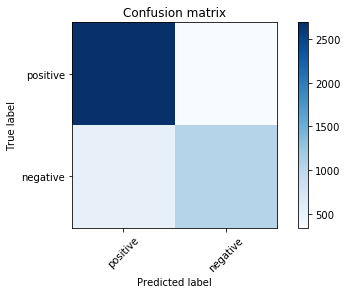

In [408]:
c = confusion_matrix(test_ufn["Usefulness"], prediction['Logistic_Usefulness'])
plt.figure()
plot_confusion_matrix(c)

In [410]:
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# Useful to select only certain features in a dataset for forwarding through a pipeline
# See: http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, data_dict):
        return data_dict[self.key]

train_ufn2, test_ufn2 = train_test_split(messages_ufn, test_size=0.2)

ufn_pipe2 = Pipeline([
   ('union', FeatureUnion(
       transformer_list = [
           ('summary', Pipeline([
               ('textsel', ItemSelector(key='Summary')),
               ('vect', CountVectorizer(min_df = 1, ngram_range = (1, 4))),
               ('tfidf', TfidfTransformer())])),
          ('score', ItemSelector(key=['Score']))
       ],
       transformer_weights = {
           'summary': 0.2,
           'score': 0.8
       }
   )),
   ('model', LogisticRegression(C=1e5))
])

ufn_result2 = ufn_pipe2.fit(train_ufn2, train_ufn2["Usefulness"])
prediction['Logistic_Usefulness2'] = ufn_pipe2.predict(test_ufn2)
print(metrics.classification_report(test_ufn2["Usefulness"], prediction['Logistic_Usefulness2']))

             precision    recall  f1-score   support

     useful       0.85      0.90      0.88      2976
    useless       0.80      0.72      0.76      1637

avg / total       0.83      0.84      0.83      4613

